In [129]:
%matplotlib inline
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from collections import OrderedDict
import statsmodels.formula.api as smf

In [136]:
class GeneticVariable(object):
    """Simulate a genetic variable."""
    def __init__(self, name, n, effect, maf, dosage_var=None, call_rate=1):
        self.name = name
        self.n = n
        self.effect = effect
        self.maf = maf
        self.dosage_var = dosage_var
        self.call_rate = call_rate
        
        self.x = self._build_genotypes()
        
    def _build_genotypes(self):
        """Build a vector of genotypes or dosage."""
        x = np.zeros(self.n)
        
        # Frequencies derived from HWE.
        num_hetero = 2 * self.maf * (1 - self.maf) * self.n
        num_homo_minor = self.maf ** 2 * self.n
        
        x[:num_hetero] = 1
        x[num_hetero:num_hetero+num_homo_minor] = 2
        np.random.shuffle(x)
        
        # Add noise for dosage values if needed.
        if self.dosage_var:
            x[x == 0] += np.abs(
                np.random.normal(0, self.dosage_var, len(x[x == 0]))
            )
            x[x == 1] += np.random.normal(0, self.dosage_var, len(x[x == 1]))
            x[x == 2] -= np.abs(
                np.random.normal(0, self.dosage_var, len(x[x == 2]))
            )

        # Mask some values if the call rate is not 1.
        if self.call_rate < 1:
            missing_rate = 1 - self.call_rate
            missing_number = missing_rate * self.n
            missing_idx = np.arange(0, self.n)
            np.random.shuffle(missing_idx)
            missing_idx = missing_idx[:missing_number]
            x[missing_idx] = np.nan
        
        return x
    
    def __repr__(self):
        return self.name
        
        
class Simulation(object):
    def __init__(self, predictors, outcome_type="discrete",
                 interactions=None, noise=0, intercept=0):
        self.model = "y ~ {} + {}".format(
            " + ".join([repr(e) for e in predictors]),
            " + ".join(["{} x {}".format(*k) for k in interactions.keys()])
        )

        self.predictors = predictors
        self.outcome_type = outcome_type
        self.intercept = intercept
        self.interactions = interactions
        self.noise = noise
        self.y = self._build_outcome()
    
    def _build_outcome(self):
        assert len(set([e.n for e in self.predictors])) == 1
        n = self.predictors[0].n
        y = np.zeros(n)
        if self.outcome_type == "continuous":
            for i in range(len(y)):
                for pred in self.predictors:
                    y[i] += pred.effect * pred.x[i]
                for preds, effect in self.interactions.items():
                    pred1, pred2 = preds
                    y[i] += effect * pred1.x[i] * pred2.x[i]
        
        if self.noise > 0:
            y += np.random.normal(0, self.noise, n)
        
        y += self.intercept
        
        return y

    def plot_main_effects(self, figsize=(15, 5)):
        fig, axes = plt.subplots(1, len(self.predictors),
                                 figsize=figsize, sharey=True)
        for i, ax in enumerate(axes):
            ax.scatter(predictors[i].x, self.y)
            ax.set_xlabel(predictors[i])
            if i == 0:
                ax.set_ylabel("Outcome")
    
    def to_df(self):
        d = OrderedDict({"y": self.y})
        for pred in self.predictors:
            d[pred.name] = pred.x
            
        df = pd.DataFrame(d)
        return df

y ~ snp1 + snp2 + snp3 + snp1 x snp2


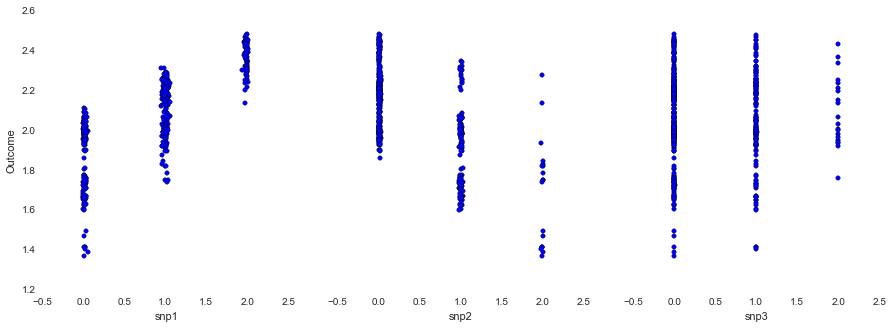

In [137]:
snp1 = GeneticVariable("snp1", 500, 0.2, 0.4, 0.02, 0.98)
snp2 = GeneticVariable("snp2", 500, -0.3, 0.2, 0.01, 0.99)
snp3 = GeneticVariable("snp3", 500, 0, 0.2, 0.001, 0.99)

predictors = [snp1, snp2, snp3]
interactions = {(snp1, snp2): 0.1, }

s = Simulation(predictors, "continuous", interactions, noise=0.05, intercept=2)
print(s.model)
s.plot_main_effects()

In [138]:
df = s.to_df()
results = smf.ols("y ~ snp1 + snp2 + snp3 + snp1*snp2", data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     2478.
Date:                Fri, 06 Mar 2015   Prob (F-statistic):          1.41e-316
Time:                        14:05:53   Log-Likelihood:                 776.73
No. Observations:                 480   AIC:                            -1543.
Df Residuals:                     475   BIC:                            -1523.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.9984      0.005    442.025      0.0